In [3]:
import cv2
import numpy as np
from numpy import cos, sin
from numpy import pi
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.transforms import GaussianBlur

In [4]:
sqrt = np.sqrt

In [11]:
img = cv2.imread("D:/Cross_Fingerprint_Images_Database/processed_contactless_2d_fingerprint_images/first_session/p1/p1.bmp")
#img = cv2.imread("D:/Acads/7th sem/EE 678/Final project/Test wvt extraction/test-img.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = torch.from_numpy(img)
img = torch.reshape(img, (1,1) + img.shape) # Reshape image to required format

In [12]:
img.shape

torch.Size([1, 1, 225, 350])

In [7]:
import cv2
import numpy as np
from numpy import cos, sin, sqrt
from numpy import pi
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.transforms import GaussianBlur

pi = np.pi
cos = np.cos
sin = np.sin
sqrt = np.sqrt

class ScatteringNetwork(torch.nn.Module):
    '''
    Class to implement the scattering network with morlet wavelet  
    '''

    def __init__(self, N = 12, omega0 = 6, theta_div = 5, ds = 8):
        super(ScatteringNetwork, self).__init__()
        self.GausBlur = GaussianBlur(kernel_size=7, sigma=1)
        
        # Define morlet wavelet convolution matrix
        l = 11 # Length of discretized morlet wavelet chosen for computation
        c = int(l/2) # Center coordinate of the constructed morlet wavelet 
        self.ds = ds
        # psi = np.fromfunction(lambda w,k,i,j: 
        #             np.exp(1j*omega0*((i-c)*(cos(pi*k/theta_div)+sin(pi*k/theta_div)) + (j-c)*(cos(pi*k/theta_div)-sin(pi*k/theta_div)))/(2*(2**w)) - ((i-c)**2+(j-c)**2)/(2*(2**w))), 
        #             (theta_div,J+1,l,l))

        # psi filter for scale 2^3
        psi_1 = np.fromfunction(lambda k,i,j: 
                    1/(sqrt(2*pi)*(2**3))*np.exp(1j*omega0*((i-c)*cos(pi*k/theta_div) - (j-c)*sin(pi*k/theta_div))/(2*(2**(2*3))) - ((i-c)**2+(j-c)**2)/(2*(2**(2*3)))), 
                    (theta_div,l,l))
        
        # psi filter for scale 2^0
        psi_2 = np.fromfunction(lambda k,i,j: 
                    1/(sqrt(2*pi)*(2**0))*np.exp(1j*omega0*((i-c)*cos(pi*k/theta_div) - (j-c)*sin(pi*k/theta_div))/(2*(2**(2*0))) - ((i-c)**2+(j-c)**2)/(2*(2**(2*0)))), 
                    (theta_div,l,l))

        # Convolution matrix for S1 layer
        self.psi1 = torch.cat((torch.tensor(psi_1),torch.tensor(psi_2)))
        self.psi1 = torch.reshape(self.psi1, (2*theta_div,1,l,l)) # Reshape the tensor into required format for convolution

        # Convolution matrix for S2 layer
        self.psi2 = tuple()
        for i in range(2*theta_div):
            self.psi2 = self.psi2 + tuple([self.psi1])
        self.psi2 = torch.cat(self.psi2, dim = 0)

    def forward(self, img):
        # Declare some parameters
        ds = self.ds
        out = self.GausBlur(img)
        
        # Extract S0 (downsample out by factor of 2^(J+1) i.e. 8) for now using downsampling of 2
        s0 = out[:,:,::ds,::ds]
        # print(s0.shape)

        img = img.to(torch.complex128)
        
        # Extract S1
        s1 = F.conv2d(img, self.psi1,padding="same")
        s1_fwd = torch.abs(s1)
        s1 = self.GausBlur(s1)
        #s1 = s1.to(torch.complex128)
        # print(s1.shape)

        # Extract S2
        #s2_layer1 = tuple()
        (N,C,H,W) = s1_fwd.shape
        # for i in range(C):
        #     s2_layer1 = s2_layer1 + tuple([F.conv2d(torch.reshape(s1[:,i,:,:],(N,1,H,W)), self.psi,padding="same")])
        s2_layer1 = F.conv2d(s1_fwd.to(torch.complex128), self.psi2, groups=C, padding="same")
        #s2_layer2 = torch.abs(torch.cat(tuple(s2_layer1),dim = 1))
        s2 = self.GausBlur(s2_layer1)
        # print(s2.shape)

        feature = torch.cat((s0,s1[:,:,::ds,::ds],s2[:,:,::ds,::ds]),dim = 1).to(torch.double).to(torch.float)
        # (N,C,H,W) = feature.shape
        # feature = torch.reshape(feature,(N,C*H*W)).to(torch.float64)
        
        return feature

In [13]:
scatnet  = ScatteringNetwork(theta_div = 3, ds = 4)(img)

In [14]:
print(scatnet.shape)

torch.Size([1, 43, 57, 88])


tensor(25.5592)


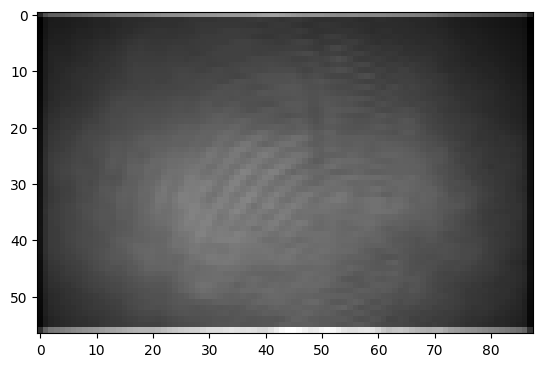

In [27]:
N = 10
"D:/Acads/7th sem/EE 678/Final project/Test wvt extraction/test-img.png"
#plt.figure(figsize=(1,1))
plt.imshow(scatnet[0,N,:,:], cmap="gray")
print(torch.median(scatnet[0,N,:,:]))

In [114]:
theta_div = 5
omega0 = 6
J = 2
# Define morlet wavelet convolution matrix
l = 11 # Length of discretized morlet wavelet chosen for computation
c = int(l/2) # Center coordinate of the constructed morlet wavelet 
psi = np.fromfunction(lambda w,k,i,j: 
                    np.exp(1j*omega0*((i-c)*cos(pi*k/theta_div) - (j-c)*sin(pi*k/theta_div))/(2*(2**w)) - ((i-c)**2+(j-c)**2)/(2*(2**w))), 
                    (J+1,theta_div,l,l))
psi = torch.tensor(psi)
psi = torch.reshape(psi, ((J+1)*theta_div,1,l,l))

psi2 = tuple()
for i in range((J+1)*theta_div):
    psi2 = psi2 + tuple([psi])
psi2 = torch.cat(psi2, dim = 0)

In [73]:
print(torch.abs(psi[11,0,3:8,3:8]))

tensor([[0.3679, 0.5353, 0.6065, 0.5353, 0.3679],
        [0.5353, 0.7788, 0.8825, 0.7788, 0.5353],
        [0.6065, 0.8825, 1.0000, 0.8825, 0.6065],
        [0.5353, 0.7788, 0.8825, 0.7788, 0.5353],
        [0.3679, 0.5353, 0.6065, 0.5353, 0.3679]], dtype=torch.float64)


In [145]:
N = 5
c = int(N/2)
gaus = np.fromfunction(lambda k,i,j: np.exp(-((i-c)**2+(j-c)**2)/(2**k)),(3,N,N))
print(gaus[2])

[[0.13533528 0.2865048  0.36787944 0.2865048  0.13533528]
 [0.2865048  0.60653066 0.77880078 0.60653066 0.2865048 ]
 [0.36787944 0.77880078 1.         0.77880078 0.36787944]
 [0.2865048  0.60653066 0.77880078 0.60653066 0.2865048 ]
 [0.13533528 0.2865048  0.36787944 0.2865048  0.13533528]]
